<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# IBM Watson OpenScale and Machine Learning Lab

This notebook should be run in a Watson Studio project, using with **Python 3.5 with Spark** runtime environment. **If you are viewing this in Watson Studio and do not see Python 3.5 with Spark in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following Cloud services:
  * Watson Machine Learning
  * Watson OpenScale

If you have a paid Cloud account, you may also provision a **Databases for PostgreSQL** or **Db2 Warehouse** service to take full advantage of integration with Watson Studio and continuous learning services. If you choose not to provision this paid service, you can use the free internal PostgreSQL storage with OpenScale, but will not be able to configure continuous learning for your model.

The notebook will train, create and deploy a German Credit Risk model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

Contents:

1. Setup
2. Credit risk prediction - model building
3. Model deployment as web-service using Watson Machine Learning
4. Configure OpenScale
5. Working with monitors
6. Historical data

# 1. Setup

## Package installation

In [264]:
!rm -rf $PIP_BUILD
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
!pip install --upgrade ibm-ai-openscale==2.1.1 --no-cache| tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade lime --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1
!pip install --upgrade pixiedust | tail -n 1

notebook 5.0.0 requires nbconvert, which is not installed.
ipywidgets 6.0.0 requires widgetsnbextension~=2.0.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
Requirement not upgraded as not directly required: jmespath<1.0.0,>=0.7.1 in /usr/local/src/conda3_runtime.v50/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client) (0.9.3)
notebook 5.0.0 requires nbconvert, which is not installed.
ipywidgets 6.0.0 requires widgetsnbextension~=2.0.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
notebook 5.0.0 requires nbconvert, which is not installed.
ipywidgets 6.0.0 requires widgetsnbextension~=2.0.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
Requirement already up-to-date: numpy in /gpfs/global_fs01/sym_shared/

## Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

In [144]:
CLOUD_API_KEY = "PASTE HERE"

In [145]:
# The code was removed by Watson Studio for sharing.

Next you will need credentials for Watson Machine Learning. If you already have a WML instance, you may use credentials for it. To provision a new Lite instance of WML, use the [Cloud catalog](https://cloud.ibm.com/catalog/services/machine-learning), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your WML credentials into the cell below.

In [146]:
WML_CREDENTIALS = {
    "apikey": "key",
    "iam_apikey_description": "description",
    "iam_apikey_name": "auto-generated-apikey",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::",
    "instance_id": "instance_id",
    "password": "password",
    "url": "https://us-south.ml.cloud.ibm.com",
    "username": "username"
}

In [147]:
# The code was removed by Watson Studio for sharing.

This lab can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you have previously configured OpenScale, it will use your existing datamart, and not interfere with any models you are currently monitoring. Do not update the cell below.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

To provision a new instance of Db2 Warehouse, locate [Db2 Warehouse in the Cloud catalog](https://cloud.ibm.com/catalog/services/db2-warehouse), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Db2 Warehouse credentials into the cell below.

To provision a new instance of Databases for PostgreSQL, locate [Databases for PostgreSQL in the Cloud catalog](https://cloud.ibm.com/catalog/services/databases-for-postgresql), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Databases for PostgreSQL credentials into the cell below.

In [148]:
DB_CREDENTIALS = None

In [149]:
# The code was removed by Watson Studio for sharing.

__If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service.__ If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the __KEEP_MY_INTERNAL_POSTGRES__ variable below to __False__ below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. __*NO DATA MIGRATION WILL OCCUR.*__

In [195]:
KEEP_MY_INTERNAL_POSTGRES = True

# 2. Credit risk prediction - model building

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

## Load and explore data

### Load the training data from github

In [151]:
!rm credit_risk_training.csv
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_data_biased_training.csv

rm: cannot remove ‘credit_risk_training.csv’: No such file or directory
--2019-03-04 02:18:25--  https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv.4’

100%[======================================>] 689,622     --.-K/s   in 0.02s   

2019-03-04 02:18:25 (26.7 MB/s) - ‘german_credit_data_biased_training.csv.4’ saved [689622/689622]



In [152]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="german_credit_data_biased_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='0_to_200', LoanDuration=31, CreditHistory='credits_paid_to_date', LoanPurpose='other', LoanAmount=1889, ExistingSavings='100_to_500', EmploymentDuration='less_1', InstallmentPercent=3, Sex='female', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='savings_insurance', Age=32, InstallmentPlans='none', Housing='own', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='No Risk')

### Explore data

In [153]:
df_data.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [154]:
print("Number of records: " + str(df_data.count()))

Number of records: 5000


In [155]:
pd_data

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
5,no_checking,32,outstanding_credit,vacation,9604,500_to_1000,greater_7,6,male,co-applicant,...,unknown,57,none,free,2,skilled,2,yes,yes,Risk
6,no_checking,9,prior_payments_delayed,car_new,1032,100_to_500,4_to_7,3,male,none,...,savings_insurance,41,none,own,1,management_self-employed,1,none,yes,No Risk
7,less_0,16,credits_paid_to_date,vacation,3109,less_100,4_to_7,3,female,none,...,car_other,36,none,own,2,skilled,1,none,yes,No Risk
8,0_to_200,11,credits_paid_to_date,car_new,4553,less_100,less_1,3,female,none,...,savings_insurance,22,none,own,1,management_self-employed,1,none,yes,No Risk
9,no_checking,35,outstanding_credit,appliances,7138,500_to_1000,greater_7,5,male,co-applicant,...,unknown,49,none,free,2,skilled,2,yes,yes,Risk


In [157]:
from pixiedust import display

display(df_data)

## Create a model

In [158]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Spark German Risk Model - Final"
DEPLOYMENT_NAME = "Spark German Risk Deployment - Final"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 4016
Number of records for evaluation: 984


In [159]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

si_CheckingStatus = StringIndexer(inputCol = 'CheckingStatus', outputCol = 'CheckingStatus_IX')
si_CreditHistory = StringIndexer(inputCol = 'CreditHistory', outputCol = 'CreditHistory_IX')
si_LoanPurpose = StringIndexer(inputCol = 'LoanPurpose', outputCol = 'LoanPurpose_IX')
si_ExistingSavings = StringIndexer(inputCol = 'ExistingSavings', outputCol = 'ExistingSavings_IX')
si_EmploymentDuration = StringIndexer(inputCol = 'EmploymentDuration', outputCol = 'EmploymentDuration_IX')
si_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_IX')
si_OthersOnLoan = StringIndexer(inputCol = 'OthersOnLoan', outputCol = 'OthersOnLoan_IX')
si_OwnsProperty = StringIndexer(inputCol = 'OwnsProperty', outputCol = 'OwnsProperty_IX')
si_InstallmentPlans = StringIndexer(inputCol = 'InstallmentPlans', outputCol = 'InstallmentPlans_IX')
si_Housing = StringIndexer(inputCol = 'Housing', outputCol = 'Housing_IX')
si_Job = StringIndexer(inputCol = 'Job', outputCol = 'Job_IX')
si_Telephone = StringIndexer(inputCol = 'Telephone', outputCol = 'Telephone_IX')
si_ForeignWorker = StringIndexer(inputCol = 'ForeignWorker', outputCol = 'ForeignWorker_IX')

In [160]:
si_Label = StringIndexer(inputCol="Risk", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [161]:
va_features = VectorAssembler(inputCols=["CheckingStatus_IX", "CreditHistory_IX", "LoanPurpose_IX", "ExistingSavings_IX", "EmploymentDuration_IX", "Sex_IX", \
                                         "OthersOnLoan_IX", "OwnsProperty_IX", "InstallmentPlans_IX", "Housing_IX", "Job_IX", "Telephone_IX", "ForeignWorker_IX", \
                                         "LoanDuration", "LoanAmount", "InstallmentPercent", "CurrentResidenceDuration", "LoanDuration", "Age", "ExistingCreditsCount", \
                                         "Dependents"], outputCol="features")

In [162]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_CheckingStatus, si_CreditHistory, si_EmploymentDuration, si_ExistingSavings, si_ForeignWorker, si_Housing, si_InstallmentPlans, si_Job, si_LoanPurpose, si_OthersOnLoan,\
                               si_OwnsProperty, si_Sex, si_Telephone, si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [163]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.704369


# 3. Model deployment as web-service using Watson Machine Learning

## Publish model

In [164]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

### Remove existing model and deployment

In [165]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

Deleting deployment id 46e33b4c-d6b4-42d1-9871-a9a7d329b616
Deleting model id 17157dc2-f850-4a84-8915-dfdb81d64c3d
------------------------------------  ------------------------------------  ------------------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK
67f09f99-c815-4b46-bf5a-76c747d6bb7e  AIOS Spark German Risk model          2019-02-28T13:44:51.718Z  mllib-2.1
c94c4b31-5f89-4259-b9da-dd79f3f8bf33  AIOS Spark German Risk model          2019-02-28T13:25:21.674Z  mllib-2.1
490de02c-7190-4756-8e3b-7f1d6ba7134a  SVCHighlights                         2019-02-26T12:22:32.340Z  scikit-learn-0.19
8d4649e7-ff64-4cea-800d-f1ac88e54c57  SVCHighlights                         2019-02-25T09:34:56.877Z  scikit-learn-0.19
0d2ad5af-40b9-4dd0-ba11-8badcf9cb1c4  SVCHighlights                         2019-02-25T09:24:23.692Z  scikit-learn-0.19
b83399e3-882c-4459-bc45-127a7c16d6f9  Dummy model for issue with pand

In [166]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": area_under_curve,
           "threshold": 0.7
        }
    ]
}

In [167]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props, training_data=train_data, pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


In [168]:
model_uid

'6336efa7-a450-4027-a270-ad92a020129e'

## Create web-service and score

In [169]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '6336efa7-a450-4027-a270-ad92a020129e' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f411e2bb-f4d2-467d-8c79-2febf8ccc2f4'
------------------------------------------------------------------------------------------------


Model id: 6336efa7-a450-4027-a270-ad92a020129e
Deployment id: f411e2bb-f4d2-467d-8c79-2febf8ccc2f4


### Scoring

In [186]:
import json

credit_risk_scoring_endpoint = wml_client.deployments.get_scoring_url(deployment)

print('scoring_url', credit_risk_scoring_endpoint)

fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}

print('scoring payload', json.dumps(payload_scoring, indent=2))

scoring_url https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/f411e2bb-f4d2-467d-8c79-2febf8ccc2f4/online
scoring payload {
  "fields": [
    "CheckingStatus",
    "LoanDuration",
    "CreditHistory",
    "LoanPurpose",
    "LoanAmount",
    "ExistingSavings",
    "EmploymentDuration",
    "InstallmentPercent",
    "Sex",
    "OthersOnLoan",
    "CurrentResidenceDuration",
    "OwnsProperty",
    "Age",
    "InstallmentPlans",
    "Housing",
    "ExistingCreditsCount",
    "Job",
    "Dependents",
    "Telephone",
    "ForeignWorker"
  ],
  "values": [
    [
      "no_checking",
      13,
      "credits_paid_to_date",
      "car_new",
      1343,
      "100_to_500",
      "1_to_4",
      2,
      "female",
      "none",
      3,
      "savings_insurance",
      46,
      "none",
      "own",
      2,
      "skilled",
      1,
      "none",
      "yes"
    ],
    [
      "0_to_200",
      13,
      "prior_payments_delayed",
      "retrai

In [188]:
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

print('scoring response', json.dumps(scoring_response, indent=2))

scoring response {
  "fields": [
    "CheckingStatus",
    "LoanDuration",
    "CreditHistory",
    "LoanPurpose",
    "LoanAmount",
    "ExistingSavings",
    "EmploymentDuration",
    "InstallmentPercent",
    "Sex",
    "OthersOnLoan",
    "CurrentResidenceDuration",
    "OwnsProperty",
    "Age",
    "InstallmentPlans",
    "Housing",
    "ExistingCreditsCount",
    "Job",
    "Dependents",
    "Telephone",
    "ForeignWorker",
    "CheckingStatus_IX",
    "CreditHistory_IX",
    "EmploymentDuration_IX",
    "ExistingSavings_IX",
    "ForeignWorker_IX",
    "Housing_IX",
    "InstallmentPlans_IX",
    "Job_IX",
    "LoanPurpose_IX",
    "OthersOnLoan_IX",
    "OwnsProperty_IX",
    "Sex_IX",
    "Telephone_IX",
    "features",
    "rawPrediction",
    "probability",
    "prediction",
    "predictedLabel"
  ],
  "values": [
    [
      "no_checking",
      13,
      "credits_paid_to_date",
      "car_new",
      1343,
      "100_to_500",
      "1_to_4",
      2,
      "female",
    

# 4. Configure OpenScale

In [189]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

### Get AI OpenScale GUID

In [190]:
import requests

AIOS_GUID = None
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': CLOUD_API_KEY
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

resources = json.loads(requests.get('https://resource-controller.cloud.ibm.com/v2/resource_instances', headers=iam_headers).text)['resources']
for resource in resources:
    if "aiopenscale" in resource['id'].lower():
        AIOS_GUID = resource['guid']
        
AIOS_CREDENTIALS = {
    "instance_guid": AIOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if AIOS_GUID is None:
    print('AI OpenScale GUID NOT FOUND')
else:
    print(AIOS_GUID)

e3a38ab0-3884-454c-abc0-5e535eec36e6


## Create schema and datamart

In [191]:
ai_client = APIClient(aios_credentials=AIOS_CREDENTIALS)
ai_client.version

'2.1.0.46'

In [193]:
from ibm_ai_openscale.utils import create_postgres_schema

SCHEMA_NAME = 'openscale_lab'
create_postgres_schema(DB_CREDENTIALS, schema_name=SCHEMA_NAME)

### Set up datamart

In [196]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        try:
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
        except:
            print('Setup failed, trying Db2 setup')
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS, schema=DB_CREDENTIALS['username'])
    

Using existing external datamart


In [197]:
data_mart_details = ai_client.data_mart.get_details()

## Bind machine learning engines

In [198]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

Warning during bind instance.
Status code: 409, body: {"trace":"ZGZjNjE0MWEtMmYwYS00MGQzLWI1M2EtY2M4NGE3YzQwZWYx","errors":[{"code":"AIQCS0010W","message":"Service Binding with this id is already defined"}]}


a73bf76d-a663-448a-b771-4f651f73d54e,WML instance,watson_machine_learning,2019-03-01T11:44:11.647Z


In [199]:
print(binding_uid)

a73bf76d-a663-448a-b771-4f651f73d54e


In [200]:
ai_client.data_mart.bindings.list_assets()

6336efa7-a450-4027-a270-ad92a020129e,Spark German Risk Model - Final,2019-03-04T08:20:16.543Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
67f09f99-c815-4b46-bf5a-76c747d6bb7e,AIOS Spark German Risk model,2019-02-28T13:45:00.965Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
c94c4b31-5f89-4259-b9da-dd79f3f8bf33,AIOS Spark German Risk model,2019-02-28T13:25:31.646Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
8d4649e7-ff64-4cea-800d-f1ac88e54c57,SVCHighlights,2019-02-25T09:37:59.520Z,model,scikit-learn-0.19,a73bf76d-a663-448a-b771-4f651f73d54e,False
d5aee97c-5347-42ae-865c-794c431d750c,AIOS SPSS Customer Model,2019-02-21T09:43:15.257Z,model,spss-modeler-18.0,a73bf76d-a663-448a-b771-4f651f73d54e,False
9a7e44e9-5464-4ef8-a136-dd3ed3d41df2,AIOS SPSS Customer Model,2019-02-21T09:41:40.332Z,model,spss-modeler-18.0,a73bf76d-a663-448a-b771-4f651f73d54e,False
986a13c7-d0a3-4f18-83dd-37467d82ae8b,AIOS SPSS Customer Model,2019-02-21T09:16:14.492Z,model,spss-modeler-18.0,a73bf76d-a663-448a-b771-4f651f73d54e,False
199ee3ae-0b4a-4e5d-9434-1ffc7131c3d5,AIOS SPSS Customer Model,2019-02-21T09:10:32.067Z,model,spss-modeler-18.0,a73bf76d-a663-448a-b771-4f651f73d54e,False
6bd6283d-771a-439c-bbaf-8f81f022bbb2,AIOS Spark German Risk model,2019-02-19T13:16:21.234Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
9dc24903-f6b7-4ddb-8239-3d30249e3ea7,AIOS Xgboost Agaricus Model,2019-02-13T12:17:46.317Z,model,xgboost-0.80,a73bf76d-a663-448a-b771-4f651f73d54e,False
2ac283ef-5138-47d6-9743-d4b230e3f056,AIOS Xgboost Agaricus Model,2019-02-13T12:14:46.726Z,model,xgboost-0.80,a73bf76d-a663-448a-b771-4f651f73d54e,False


## Subscriptions

### Remove existing credit risk subscriptions

In [201]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

Deleted existing subscription for Spark German Risk Model - Final


In [202]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    prediction_column='predictedLabel',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"]
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [203]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

6336efa7-a450-4027-a270-ad92a020129e,Spark German Risk Model - Final,model,a73bf76d-a663-448a-b771-4f651f73d54e,2019-03-04T08:39:17.543Z


In [204]:
subscription_details = subscription.get_details()

# 5. Working with monitors

### Score the model so we can configure monitors

In [205]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

f411e2bb-f4d2-467d-8c79-2febf8ccc2f4
https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/f411e2bb-f4d2-467d-8c79-2febf8ccc2f4/online


In [206]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

## Quality and feedback monitoring

### Enable quality monitoring

Wait ten seconds to allow the payload logging table to be set up before we begin enabling monitors.

In [207]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

### Feedback logging

In [208]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/additional_feedback_data.json

--2019-03-04 02:40:07--  https://raw.githubusercontent.com/emartensibm/german-credit/master/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: ‘additional_feedback_data.json’

100%[======================================>] 16,506      --.-K/s   in 0.002s  

2019-03-04 02:40:07 (9.16 MB/s) - ‘additional_feedback_data.json’ saved [16506/16506]



In [209]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
subscription.feedback_logging.store(additional_feedback_data['data'])

In [210]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2019-03-04 08:40:08.855000+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2019-03-04 08:40:08.855000+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2019-03-04 08:40:08.855000+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2019-03-04 08:40:08.855000+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2019-03-04 08:40:08.855000+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2019-03-04 08:40:08.855000+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-03-04 08:40:08.855000+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-03-04 08:40:08.855000+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2019-03-04 08:40:08.855000+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2019-03-04 08:40:08.855000+00:00


### Run model performance check

In [211]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run b6f4c216-a43c-4f4b-9d24-60c51ee9044f 




initializing.
completed

---------------------------
 Successfully finished run 
---------------------------




In [212]:
subscription.quality_monitoring.show_table()

2019-03-04 08:40:09.420000+00:00,0.7469512195121951,0.7,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,Accuracy_evaluation_b6f4c216-a43c-4f4b-9d24-60c51ee9044f,


In [217]:
quality_metrics_pandas = subscription.quality_monitoring.get_table_content()

quality_metrics_pandas

,ts,quality,quality_threshold,binding_id,subscription_id,deployment_id,process,asset_revision
0,2019-03-04 08:40:09.420000+00:00,0.746951,0.7,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,Accuracy_evaluation_b6f4c216-a43c-4f4b-9d24-60...,


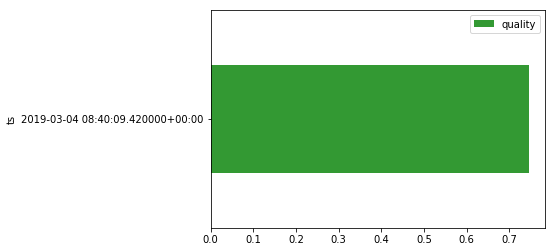

In [218]:
%matplotlib inline

quality_metrics_pandas.plot.barh(x='ts', y='quality', color='g', alpha=0.8);

## Fairness monitoring

### Configuration

In [219]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=1000,
            training_data=pd_data
        )

### Run

In [222]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=f411e2bb-f4d2-467d-8c79-2febf8ccc2f4 




RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [223]:
subscription.fairness_monitoring.show_table()

2019-03-04 08:47:31.999752+00:00,Sex,female,True,0.949,73.0,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:31.999752+00:00,Age,"[18, 25]",False,0.991,79.58057395143487,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:29.083410+00:00,Sex,female,True,0.949,73.0,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:29.083410+00:00,Age,"[18, 25]",False,0.991,79.58057395143487,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,


## Explainability

In [224]:
subscription.explainability.enable(training_data=pd_data)

### Get transaction id (scoring_id)

In [234]:
sample_transaction_id=subscription.payload_logging.get_table_content(limit=1)['scoring_id'][0]

In [237]:
run_details = subscription.explainability.run(transaction_id=sample_transaction_id, cem=False)




 Looking for explanation for c99a7e5bf7f6a050748dd23af6daf783-246 




in_progress
finished

---------------------------
 Successfully finished run 
---------------------------




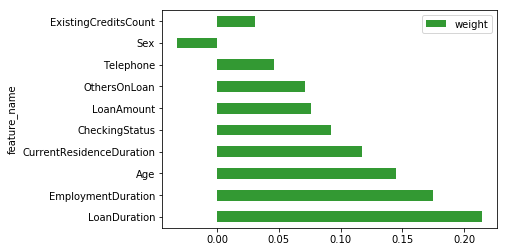

In [246]:
explanation_result = pd.DataFrame.from_dict(run_details['entity']['predictions'][0]['explanation_features'])
explanation_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# 6. Historical data

## Score the model again now that monitoring is configured

In [247]:
!rm german_credit_feed.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_feed.json

--2019-03-04 03:10:40--  https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_feed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076547 (2.9M) [text/plain]
Saving to: ‘german_credit_feed.json’

100%[======================================>] 3,076,547   --.-K/s   in 0.1s    

2019-03-04 03:10:42 (29.5 MB/s) - ‘german_credit_feed.json’ saved [3076547/3076547]



Score 1000 randomly chosen records

In [248]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(1000):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

# Insert historical payloads

In [249]:
!rm payload_history*.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_1.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_2.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_3.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_4.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_5.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_6.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_7.json

--2019-03-04 03:10:45--  https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3817949 (3.6M) [text/plain]
Saving to: ‘payload_history_1.json’

100%[======================================>] 3,817,949   --.-K/s   in 0.06s   

2019-03-04 03:10:45 (60.1 MB/s) - ‘payload_history_1.json’ saved [3817949/3817949]

--2019-03-04 03:10:45--  https://raw.githubusercontent.com/emartensibm/german-credit/master/payload_history_2.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818645 (3.6M) [text/plain]
Saving to: ‘payload_history_2.json

In [250]:
historyDays = 7

In [252]:
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
import datetime
import time

for day in range(historyDays):
    print('Loading day {}'.format(day + 1))
    history_file = 'payload_history_' + str(day + 1) + '.json'
    with open(history_file) as f:
        payloads = json.load(f)
        hourly_records = int(len(payloads) / 24)
        index = 0
        for hour in range(24):
            recordsList = []
            for i in range(hourly_records):
                score_time = str(datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1))))
                recordsList.append(PayloadRecord(request=payloads[index]['request'], response=payloads[index]['response'], scoring_timestamp=score_time))
                index += 1
            subscription.payload_logging.store(records=recordsList)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


In [253]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

e3a38ab0-3884-454c-abc0-5e535eec36e6


In [254]:
performance_metrics_url = 'https://api.aiopenscale.cloud.ibm.com' + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/e3a38ab0-3884-454c-abc0-5e535eec36e6/metrics


## Insert historical fairness metrics

In [255]:
!rm fairness_history.json
!wget https://raw.githubusercontent.com/emartensibm/german-credit/master/fairness_history.json

--2019-03-04 03:21:49--  https://raw.githubusercontent.com/emartensibm/german-credit/master/fairness_history.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 877247 (857K) [text/plain]
Saving to: ‘fairness_history.json’

100%[======================================>] 877,247     --.-K/s   in 0.04s   

2019-03-04 03:21:50 (20.2 MB/s) - ‘fairness_history.json’ saved [877247/877247]



In [256]:
import random
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('fairness_history.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        qualityMetric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': random.choice(payloads)
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical quality metrics

In [257]:
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical performance metrics

In [258]:
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }

        response = requests.post(performance_metrics_url, json=[performanceMetric], headers=iam_headers)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Run fairness monitor

Kick off a fairness monitor run on current data. Depending on how fast the monitor runs, the table may not contain the most recent results.

In [259]:
run_details = subscription.fairness_monitoring.run()

In [260]:
subscription.fairness_monitoring.show_table()

2019-03-04 08:47:29.083410+00:00,Sex,female,True,0.949,73.0,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:29.083410+00:00,Age,"[18, 25]",False,0.991,79.58057395143487,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:31.999752+00:00,Sex,female,True,0.949,73.0,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:47:31.999752+00:00,Age,"[18, 25]",False,0.991,79.58057395143487,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:21:51+00:00,Sex,female,True,0.888,67.5,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,
2019-03-04 08:21:51+00:00,Age,"[18, 25]",False,1.017,78.68852459016394,a73bf76d-a663-448a-b771-4f651f73d54e,6336efa7-a450-4027-a270-ad92a020129e,6336efa7-a450-4027-a270-ad92a020129e,f411e2bb-f4d2-467d-8c79-2febf8ccc2f4,


## Additional data to help debugging

In [261]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: e3a38ab0-3884-454c-abc0-5e535eec36e6
Model: 6336efa7-a450-4027-a270-ad92a020129e
Deployment: f411e2bb-f4d2-467d-8c79-2febf8ccc2f4
Binding: a73bf76d-a663-448a-b771-4f651f73d54e
Scoring URL: https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/f411e2bb-f4d2-467d-8c79-2febf8ccc2f4/online


## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [262]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

,scoring_id,predictedLabel,probability
0,5e82dc20779a5d2d8cf82f02d436bd27-1,No Risk,"[0.9865351234860136, 0.013464876513986432]"
1,5e82dc20779a5d2d8cf82f02d436bd27-3,Risk,"[0.2550112156683831, 0.744988784331617]"
2,5e82dc20779a5d2d8cf82f02d436bd27-4,Risk,"[0.466928625254432, 0.533071374745568]"
3,5e82dc20779a5d2d8cf82f02d436bd27-2,Risk,"[0.4218412971893901, 0.5781587028106099]"
4,5e82dc20779a5d2d8cf82f02d436bd27-6,No Risk,"[0.9755608589320909, 0.024439141067909127]"
5,5e82dc20779a5d2d8cf82f02d436bd27-7,No Risk,"[0.6873052726939807, 0.3126947273060193]"
6,5e82dc20779a5d2d8cf82f02d436bd27-8,No Risk,"[0.774082206544972, 0.2259177934550281]"
7,5e82dc20779a5d2d8cf82f02d436bd27-9,Risk,"[0.2589293228130821, 0.7410706771869179]"
8,5e82dc20779a5d2d8cf82f02d436bd27-5,No Risk,"[0.949407418445382, 0.05059258155461788]"
9,5e82dc20779a5d2d8cf82f02d436bd27-10,Risk,"[0.2701803354624487, 0.7298196645375513]"


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

## Next steps

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and cal be deleted if necessary.